In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from math import exp, sqrt
from sklearn.model_selection import train_test_split

## Dataset and Exploratory Data Analysis

In [2]:
all_beauty = pd.read_csv('All_beauty.csv', header=None)
column_names = ['item', 'user', 'rating', 'timestamp']
all_beauty.columns = column_names

In [52]:
all_beauty

,item,user,rating,timestamp
0,0143026860,A1V6B6TNIC10QE,1.0,1424304000
1,0143026860,A2F5GHSXFQ0W6J,4.0,1418860800
2,0143026860,A1572GUYS7DGSR,4.0,1407628800
3,0143026860,A1PSGLFK1NSVO,5.0,1362960000
4,0143026860,A6IKXKZMTKGSC,5.0,1324771200
...,...,...,...,...
371340,B01HJEGTYK,A202DCI7TV1022,1.0,1500508800
371341,B01HJEGTYK,A3FSOR5IJOFIBE,5.0,1489622400
371342,B01HJEGTYK,A1B5DK6CTP2P24,5.0,1488326400
371343,B01HJEGTYK,A23OUYS5IRMJS9,2.0,1487635200


In [53]:
print(all_beauty.describe()['rating'])

count    371345.000000
mean          4.112093
std           1.362099
min           1.000000
25%           4.000000
50%           5.000000
75%           5.000000
max           5.000000
Name: rating, dtype: float64


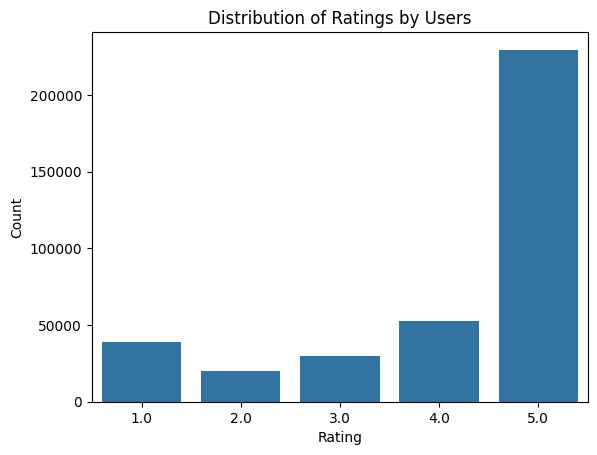

In [54]:
# Distribution of ratings by users
sns.countplot(x='rating', data=all_beauty)
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Distribution of Ratings by Users')
plt.show()

We can see here in the distribution of ratings and in the histogram above that a large majority of users provided a 5-star rating for their product from Amazon. Additionally, the mean rating was over 4 stars meaning that most users thoroughly enjoyed the beauty products they received.

In [55]:
unique_users = all_beauty['user'].nunique()
unique_items = all_beauty['item'].nunique()
print(f"Number of unique users: {unique_users}")
print(f"Number of unique items: {unique_items}")

Number of unique users: 324038
Number of unique items: 32586


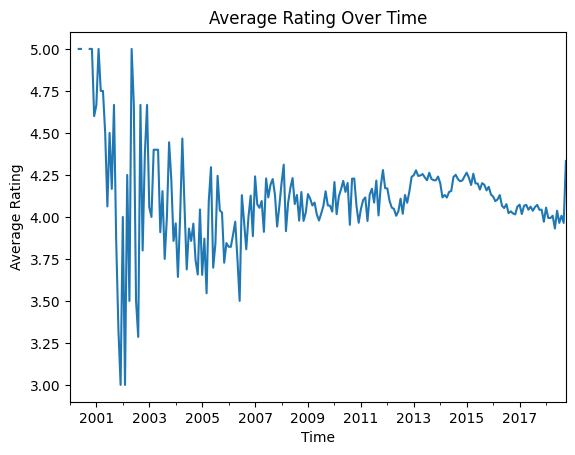

In [3]:
all_beauty['dates'] = pd.to_datetime(all_beauty['timestamp'], unit='s')
all_beauty.set_index('dates', inplace=True)

# Plot the average rating over time
all_beauty['rating'].resample('M').mean().plot()
plt.xlabel('Time')
plt.ylabel('Average Rating')
plt.title('Average Rating Over Time')
plt.show()

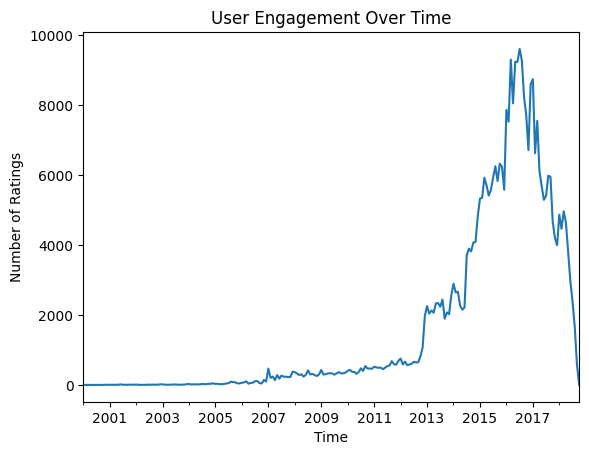

In [4]:
all_beauty = all_beauty.reset_index()
all_beauty.set_index('dates', inplace=True)

# Plot the number of ratings over time
all_beauty.resample('M').size().plot()
plt.xlabel('Time')
plt.ylabel('Number of Ratings')
plt.title('User Engagement Over Time')
plt.show()

In this graphic we can see the average ratings that were given over time. We see far more variability at the start of the time period with ratings varying largely, presumably due to less popularity of Amazon in the earlier 2000's. Now though, with Amazons extreme popularity, it would make sense that more people are providing ratings and that it would average out closer to a single value with less variability. It is also interesting to see that the dataset seems to have far less data in the time between 2017 and the last rating which was given on October 2nd 2018.

In [5]:
top_users = all_beauty['user'].value_counts().head(5)
top_items = all_beauty['item'].value_counts().head(5)
top_users, top_items

(user
 A2GJX2KCUSR0EI    27
 A1KSC91G9AIY2Z    23
 A1EGCED01USBA9    21
 A22CW0ZHY3NJH8    21
 AENH50GW3OKDA     20
 Name: count, dtype: int64,
 item
 B000FOI48G    8672
 B000GLRREU    8341
 1620213982    4792
 B001QY8QXM    4544
 B01DKQAXC0    4246
 Name: count, dtype: int64)

The data above shows us the largest number of ratings made by a single user and also the products that were rated the most. We can see the most items a single user rated was 27 and the most frequently rated item was rated 8672 times.

After conducting this EDA, it is apparent that there are a few things we should look out for when trying to predict the star rating given a user/item pair and a timestamp. A huge number of the ratings are 5 stars so we need to make sure our model is not overfitting and only predicting 5-star ratings for all user/item pairs. Additionally, we must find the correct way to weight a rating based on the timestamp due to the unique distribution of ratings over time (since most of them came in a 4 year period). Dealing with these factors are critical in maximizing the performance of our predictive model. We also can see that there are about 10 unique users for every item in the dataset, which is something to keep in mind while we are building our model. Additionally there are 324038 unique users and only 371345 data entries which means users may have only rated 1 item. Thus means we will have limited user data to work with and is something we will have to work around.

## Rating Prediction

Given our dataset, we will be predicting the rating given a particular user/item pair. In order to accomplish out predictive task of predicting ratings, we will implement our model based on time-weight collaborative filtering where we utilize some similarity function and an exponential decay function. To make this predictive model feasible, we would have to extract the user/item pairs along with the ratings and the timestamps. In this case of our prediction task, the user/item pairs and timestamps are crucial for creating our predictions where the ratings will serve as our true labels that we will compare to our predictions generated by our model. To account for the uneven distribution of ratings, we will incorporate a temporal factors (timestamps) through the use of a decay function that will emphasize newer ratings while putting less emphasis on older items into our standard collaborative filtering for rating prediction. In order to evaluate the validity of our predictions from our model, we will compare the MSE results with the baseline of just predicting the average rating for all points.

In order to accomplish our goal of making predictions using a time-weight collaborative filtering approach, we will need to preprocess our data into default dictionaries that maps users to items they rated and another that maps items to users who rated it. We will also need a default dictionary that maps a user to all their review entries and a dictionary that maps a user/item pair to its corresponding rating.

In [6]:
all_beauty = all_beauty.reset_index()

In [9]:
beauty_train = all_beauty[:int(len(all_beauty)*0.8)]
beauty_test = all_beauty[int(len(all_beauty)*0.8):]

In [10]:
usersPerItem = defaultdict(set) # Maps an item to the users who rated it
itemsPerUser = defaultdict(set) # Maps a user to the items that they rated
itemNames = {}
ratingDict = {} # To retrieve a rating for a specific user/item pair
reviewsPerUser = defaultdict(list)
    
for _, row in beauty_train.iterrows():
    user, item = row['user'], row['item']
    usersPerItem[item].add(user)
    itemsPerUser[user].add(item)
    reviewsPerUser[user].append(row)

for _, row in all_beauty.iterrows():
    user, item = row['user'], row['item']
    ratingDict[(user,item)] = row['rating']

In [11]:
userAverages = {}
itemAverages = {}

for u in itemsPerUser:
    rs = [ratingDict[(u,i)] for i in itemsPerUser[u]]
    userAverages[u] = sum(rs) / len(rs)
    
for i in usersPerItem:
    rs = [ratingDict[(u,i)] for u in usersPerItem[i]]
    itemAverages[i] = sum(rs) / len(rs)


In [12]:
ratingMean = sum([r for r in beauty_train['rating']]) / len(beauty_train['rating'])

## Predictive Models

To ensure that we are optimizing the accuracy of our model, we will be utilizing a 80/20 train-test split to train our predictive models and we will be testing our model's MSE on the test set. In order to determine a similarity function that will be best to use, we will compare the MSE of collaborative-filtering predictions using Jaccard and Cosine Similarity function. Once we have determined which similarity function yields better results, will then implement time-weight collaborative filtering with the optimal similarity function in order to account for additional data noise of older reviews. We will need to optimize our hyperparameter lambda to ensure adequate performance of our model.

In [13]:
def Cosine(i1, i2):
    # Between two items
    inter = usersPerItem[i1].intersection(usersPerItem[i2])
    numer = 0
    denom1 = 0
    denom2 = 0
    for u in inter:
        numer += ratingDict[(u,i1)]*ratingDict[(u,i2)]
    for u in usersPerItem[i1]:
        denom1 += ratingDict[(u,i1)]**2
    for u in usersPerItem[i2]:
        denom2 += ratingDict[(u,i2)]**2
    denom = sqrt(denom1) * sqrt(denom2)
    if denom == 0: return 0
    return numer / denom

In [14]:
def Jaccard(s1, s2):
    numer = len(s1.intersection(s2))
    denom = len(s1.union(s2))
    if denom == 0:
        return 0
    return numer / denom

In [15]:
def MSE(y, ypred):
    diffs = [(a-b)**2 for (a,b) in zip(y,ypred)]
    return sum(diffs) / len(diffs)

In [16]:
# Cosine Similarity bases predictions
def predictRatingCosine(user,item):
    ratings = []
    similarities = []
    for d in reviewsPerUser[user]:
        i2 = d['item']
        if i2 == item: continue
        ratings.append(d['rating'] - itemAverages[i2])
        similarities.append(Cosine(item,i2))
    if (sum(similarities) > 0):
        weightedRatings = [(x*y) for x,y in zip(ratings,similarities)]
        return itemAverages[item] + sum(weightedRatings) / sum(similarities)
    else:
        # User hasn't rated any similar items
        if item in itemAverages:
            return itemAverages[item]
        return ratingMean

In [17]:
# Jaccard Similarity bases predictions (Collaborative Filtering)
def predictRatingJaccard(user,item):
    ratings = []
    similarities = []
    for d in reviewsPerUser[user]:
        i2 = d['item']
        if i2 == item: continue
        ratings.append(d['rating'] - itemAverages[i2])
        similarities.append(Jaccard(usersPerItem[item],usersPerItem[i2]))
    if (sum(similarities) > 0):
        weightedRatings = [(x*y) for x,y in zip(ratings,similarities)]
        return itemAverages[item] + sum(weightedRatings) / sum(similarities)
    else:
        # User hasn't rated any similar items
        if item in itemAverages:
            return itemAverages[item]
        return ratingMean

In [55]:
def predictTimeWeightCosine(user, item, lamb):
    ratings = []
    similarities = []
    ts = []
    for d in reviewsPerUser[user]:
        i2 = d['item']

        if i2 == item: continue
        ratings.append(d['rating'] - itemAverages[i2])
        similarities.append(Cosine(item,i2))
        
        timestamp = d['timestamp']
        ts.append(timestamp)
       
    weightedRatings = [(x*y*exp(-(lamb)*z)) for x,y,z in zip(ratings,similarities,ts)]
    prod_denom = [(x*exp(-(lamb)*y)) for x,y in zip(similarities,ts)]    
       
    if (sum(prod_denom) > 0):
        # since timestamps in seconds(very large value), lambda value has to be close to zero in decimal
        # otherwise will overflow
        return itemAverages[item] + sum(weightedRatings) / sum(prod_denom)
    else:
        # User hasn't rated any similar items
        if item in itemAverages:
            return itemAverages[item] 
        else:
            return ratingMean

In [19]:
alwaysPredictMean = [ratingMean for d in beauty_test]

In [20]:
simPredictions = [predictRatingJaccard(d['user'], d['item']) for _,d in beauty_test.iterrows()]

In [21]:
labels = [d['rating'] for _,d in beauty_test.iterrows()]

In [22]:
MSE(alwaysPredictMean, labels)

2.689221803466304

In [23]:
MSE(simPredictions, labels)

2.240120958501206

In [33]:
cosPredictions = [predictRatingCosine(d['user'], d['item']) for _,d in beauty_test.iterrows()]

In [34]:
MSE(cosPredictions, labels) # We can see that Cosine Similarity performs better than Jaccard Similarity

2.2400954820205046

From our results, it appears that Cosine Similarity provided better results than Jaccard Similarity given our data. This would indicate that magnitude of the user's ratings are important in our dataset thus Cosine would be more able to capture this specific characteristic of the dataset. 

In [78]:
# lambdas close to 0 since timestamp are in seconds (large values) thus scale in decimals
for l in [0, 1e-10, 1e-9, 1e-8,1e-7, 1e-6, 1e-1]:
    timeCosPredictions = [predictTimeWeightCosine(d['user'], d['item'], l) for _,d in beauty_test.iterrows()]
    print(MSE(timeCosPredictions, labels))
# the appropriate order of magnitude of lambda should be between 10**(-9)or 10**(-8) 
# this is because timestamps are in seconds which is going to be a very large value

2.2400954820205046
2.2400952623847386
2.2400934043843104
2.2400873001129176
2.2401379600315185
2.24128847602426
2.24128847602426


In [112]:
for l in [2e-9, 3e-9, 4e-9, 6e-9, 7e-9, 8e-9, 9e-9, 1e-8]:
    timeCosPredictions = [predictTimeWeightCosine(d['user'], d['item'], l) for _,d in beauty_test.iterrows()]
    print(MSE(timeCosPredictions, labels))

2.2400915981493785
2.240090073016237
2.240088835288877
2.2400872283308555
2.24008685200541
2.240086748619951
2.2400869040208304
2.2400873001129176


After selecting the most optimal parameter we can see that the the MSE has improved from the collaborative-filtering model alone. Once we have accounted for temporal features and implemented our model to weigh temporal features into our collaborative-filtering model, we can observe that increasing the lambda parameter improves the MSE of our model until we reach the optimal parameter.

Overall, we can observe that depending on the characteristics of dataset chosen, the decision of which similarity function to use might matter. In the case where the magnitude of user ratings are a key characteristc of a given dataset, the better choice of similarity function to select for a predictive model might be Cosine Similarity over Jaccard Similarity. Additionally, adding a time-weight component to the predictive model can improve performance results once the lambda parameter of the decay function has been optimized.